## Eurostsat electricity prices Half-Yearly


##### Quelle: https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205__custom_16541313/default/table?lang=en
##### Bookmark: https://ec.europa.eu/eurostat/databrowser/bookmark/d3c6c0b9-4653-48f5-a522-2aea84b5ee38?lang=en


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

# Define input/output paths
EUROSTAT_BIANNUAL_FILE = "in/prices/estat_nrg_pc_205_filtered_en.csv"
PLOT_OUT_DIR_BIANNUAL = "out/price/eurostat_biannual"
EXCEL_OUTPUT_BIANNUAL = "out/price/eurostat_electricity_prices_biannual.xlsx"

# Ensure output directories exist
os.makedirs(PLOT_OUT_DIR_BIANNUAL, exist_ok=True)


In [30]:
df_biannual_raw = pd.read_csv(EUROSTAT_BIANNUAL_FILE, delimiter=",", encoding="utf-8")

df_biannual_cleaned = df_biannual_raw[[
    "TIME_PERIOD",
    "tax",  # z. B. I_TAX oder X_TAX
    "Taxes",  # Beschreibung
    "OBS_VALUE"
]].copy()

df_biannual_cleaned = df_biannual_cleaned.dropna(subset=["OBS_VALUE"])
df_biannual_cleaned["OBS_VALUE"] = pd.to_numeric(df_biannual_cleaned["OBS_VALUE"], errors="coerce")
df_biannual_cleaned = df_biannual_cleaned.dropna(subset=["OBS_VALUE"])

df_biannual_cleaned


,TIME_PERIOD,tax,Taxes,OBS_VALUE
0,2007-S1,I_TAX,All taxes and levies included,0.1032
1,2007-S2,I_TAX,All taxes and levies included,0.1084
2,2008-S1,I_TAX,All taxes and levies included,0.1217
3,2008-S2,I_TAX,All taxes and levies included,0.1170
4,2009-S1,I_TAX,All taxes and levies included,0.1249
...,...,...,...,...
103,2022-S2,X_VAT,Excluding VAT and other recoverable taxes and ...,0.1939
104,2023-S1,X_VAT,Excluding VAT and other recoverable taxes and ...,0.1905
105,2023-S2,X_VAT,Excluding VAT and other recoverable taxes and ...,0.1776
106,2024-S1,X_VAT,Excluding VAT and other recoverable taxes and ...,0.1685


In [31]:
# Überblick über die wichtigsten Eigenschaften des Datensatzes
print(f"Zeilen: {len(df_biannual_cleaned)}")
print(f"Spalten: {list(df_biannual_cleaned.columns)}\n")

unique_periods = sorted(df_biannual_cleaned["TIME_PERIOD"].unique())
print(f"TIME_PERIODs: {unique_periods}")

unique_components = df_biannual_cleaned["Taxes"].unique()
print(f"\nBesteuerungskategorien: {unique_components}")

print("\n📊 Anzahl Beobachtungen pro Kategorie:")
print(df_biannual_cleaned["Taxes"].value_counts())

zero_value_components = (
    df_biannual_cleaned
    .groupby("Taxes")["OBS_VALUE"]
    .apply(lambda x: (x == 0).all())
)

COMPONENTS_ALL_ZERO = zero_value_components[zero_value_components].index.tolist()
print(f"\nKomponenten mit nur 0-Werten: {COMPONENTS_ALL_ZERO}")


Zeilen: 108
Spalten: ['TIME_PERIOD', 'tax', 'Taxes', 'OBS_VALUE']

TIME_PERIODs: ['2007-S1', '2007-S2', '2008-S1', '2008-S2', '2009-S1', '2009-S2', '2010-S1', '2010-S2', '2011-S1', '2011-S2', '2012-S1', '2012-S2', '2013-S1', '2013-S2', '2014-S1', '2014-S2', '2015-S1', '2015-S2', '2016-S1', '2016-S2', '2017-S1', '2017-S2', '2018-S1', '2018-S2', '2019-S1', '2019-S2', '2020-S1', '2020-S2', '2021-S1', '2021-S2', '2022-S1', '2022-S2', '2023-S1', '2023-S2', '2024-S1', '2024-S2']

Besteuerungskategorien: ['All taxes and levies included' 'Excluding taxes and levies'
 'Excluding VAT and other recoverable taxes and levies']

📊 Anzahl Beobachtungen pro Kategorie:
Taxes
All taxes and levies included                           36
Excluding taxes and levies                              36
Excluding VAT and other recoverable taxes and levies    36
Name: count, dtype: int64

Komponenten mit nur 0-Werten: []


In [32]:
df_biannual_prophet = df_biannual_cleaned.copy()

# Halbjahre in echte Zeitstempel umwandeln (S1 → 01-01, S2 → 07-01)
def parse_time_period(period):
    year, half = period.split("-")
    month = "01" if half == "S1" else "07"
    return pd.to_datetime(f"{year}-{month}-01")

df_biannual_prophet["ds"] = df_biannual_prophet["TIME_PERIOD"].apply(parse_time_period)
df_biannual_prophet["y"] = df_biannual_prophet["OBS_VALUE"]

df_biannual_prophet = df_biannual_prophet[["ds", "y", "tax", "Taxes"]]

df_biannual_prophet

,ds,y,tax,Taxes
0,2007-01-01,0.1032,I_TAX,All taxes and levies included
1,2007-07-01,0.1084,I_TAX,All taxes and levies included
2,2008-01-01,0.1217,I_TAX,All taxes and levies included
3,2008-07-01,0.1170,I_TAX,All taxes and levies included
4,2009-01-01,0.1249,I_TAX,All taxes and levies included
...,...,...,...,...
103,2022-07-01,0.1939,X_VAT,Excluding VAT and other recoverable taxes and ...
104,2023-01-01,0.1905,X_VAT,Excluding VAT and other recoverable taxes and ...
105,2023-07-01,0.1776,X_VAT,Excluding VAT and other recoverable taxes and ...
106,2024-01-01,0.1685,X_VAT,Excluding VAT and other recoverable taxes and ...


In [33]:
# Ziel-Halbjahre für die Prognose
forecast_halfyears = [(y, m) for y in [2025, 2030, 2035, 2040, 2045, 2050] for m in [1, 7]]
future_df = pd.DataFrame({
    "ds": pd.to_datetime([f"{y}-{m:02d}-01" for y, m in forecast_halfyears])
})

all_forecasts = []

for preisart, group in df_biannual_prophet.groupby("Taxes"):
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    model.fit(group[["ds", "y"]])

    forecast = model.predict(future_df.copy())
    forecast_result = forecast[["ds", "yhat"]].copy()
    forecast_result["Preisart"] = preisart
    forecast_result["Jahr"] = forecast_result["ds"].dt.year
    forecast_result["Halbjahr"] = forecast_result["ds"].dt.month.map({1: "1. Halbjahr", 7: "2. Halbjahr"})

    all_forecasts.append(forecast_result)

# Ergebnisse zusammenführen
df_prophet_forecast = pd.concat(all_forecasts, ignore_index=True)

# Umbenennen und sortieren
df_prophet_forecast.rename(columns={"yhat": "Prognose_EUR_kWh"}, inplace=True)
df_prophet_forecast = df_prophet_forecast[["Jahr", "Halbjahr", "Preisart", "Prognose_EUR_kWh"]]
df_prophet_forecast = df_prophet_forecast.sort_values(["Preisart", "Jahr", "Halbjahr"]).reset_index(drop=True)

df_prophet_forecast

20:41:23 - cmdstanpy - INFO - Chain [1] start processing
20:41:23 - cmdstanpy - INFO - Chain [1] done processing
20:41:23 - cmdstanpy - INFO - Chain [1] start processing
20:41:23 - cmdstanpy - INFO - Chain [1] done processing
20:41:23 - cmdstanpy - INFO - Chain [1] start processing
20:41:23 - cmdstanpy - INFO - Chain [1] done processing


,Jahr,Halbjahr,Preisart,Prognose_EUR_kWh
0,2025,1. Halbjahr,All taxes and levies included,0.205034
1,2025,2. Halbjahr,All taxes and levies included,0.207823
2,2030,1. Halbjahr,All taxes and levies included,0.233167
3,2030,2. Halbjahr,All taxes and levies included,0.235956
4,2035,1. Halbjahr,All taxes and levies included,0.261300
5,2035,2. Halbjahr,All taxes and levies included,0.264089
6,2040,1. Halbjahr,All taxes and levies included,0.289433
7,2040,2. Halbjahr,All taxes and levies included,0.292237
8,2045,1. Halbjahr,All taxes and levies included,0.317581
9,2045,2. Halbjahr,All taxes and levies included,0.320370


In [34]:
# Historische Daten vorbereiten
df_hist_plot = df_biannual_prophet.copy()
df_hist_plot["Type"] = "Historical"
df_hist_plot = df_hist_plot[["ds", "y", "Taxes", "Type"]].rename(columns={
    "y": "Preis_EUR_kWh",
    "Taxes": "Preisart"
})

# Prognose vorbereiten (basierend auf df_prophet_forecast von vorher)
df_forecast_plot = df_prophet_forecast.copy()
df_forecast_plot["ds"] = pd.to_datetime(
    df_forecast_plot["Jahr"].astype(str) + "-" +
    df_forecast_plot["Halbjahr"].map({"1. Halbjahr": "01", "2. Halbjahr": "07"}) + "-01"
)
df_forecast_plot["Type"] = "Predicted"
df_forecast_plot = df_forecast_plot.rename(columns={"Prognose_EUR_kWh": "Preis_EUR_kWh"})
df_forecast_plot["Preis_EUR_kWh"] = df_forecast_plot["Preis_EUR_kWh"].clip(lower=0)
df_forecast_plot = df_forecast_plot[["ds", "Preis_EUR_kWh", "Preisart", "Type"]]

# Kombinieren
df_prices_combined = pd.concat([df_hist_plot, df_forecast_plot], ignore_index=True).sort_values(["Preisart", "ds"])

df_prices_combined


,ds,Preis_EUR_kWh,Preisart,Type
0,2007-01-01,0.103200,All taxes and levies included,Historical
1,2007-07-01,0.108400,All taxes and levies included,Historical
2,2008-01-01,0.121700,All taxes and levies included,Historical
3,2008-07-01,0.117000,All taxes and levies included,Historical
4,2009-01-01,0.124900,All taxes and levies included,Historical
...,...,...,...,...
139,2040-07-01,0.163561,Excluding taxes and levies,Predicted
140,2045-01-01,0.178775,Excluding taxes and levies,Predicted
141,2045-07-01,0.180449,Excluding taxes and levies,Predicted
142,2050-01-01,0.195663,Excluding taxes and levies,Predicted


In [35]:
# Jahr & Halbjahr 
df_export = df_prices_combined.copy()
df_export["Jahr"] = df_export["ds"].dt.year
df_export["Halbjahr"] = df_export["ds"].dt.month.map({1: "H1", 7: "H2"})  # Einheitlich wie vorher

# Pivot in wide Format
df_wide_export = df_export.pivot_table(
    index=["Jahr", "Halbjahr", "Type"],
    columns="Preisart",
    values="Preis_EUR_kWh"
).reset_index()

with pd.ExcelWriter(EXCEL_OUTPUT_BIANNUAL, engine='xlsxwriter', mode='w') as writer:
    df_wide_export.to_excel(writer, sheet_name='Strompreise_Biannual', index=False)

    workbook = writer.book
    worksheet = writer.sheets['Strompreise_Biannual']

    worksheet.set_column(0, 2, 15, workbook.add_format({
        'bold': True,
        'align': 'left'
    }))

    
    eur_format = workbook.add_format({'num_format': '0.00000 "€"', 'align': 'right'})
    worksheet.set_column(3, df_wide_export.shape[1] - 1, 14, eur_format)

    # Header
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#D9D9D9',
        'align': 'center',
        'valign': 'vcenter',
        'border': 1
    })
    worksheet.set_row(0, 18, header_format)

df_wide_export


Preisart,Jahr,Halbjahr,Type,All taxes and levies included,Excluding VAT and other recoverable taxes and levies,Excluding taxes and levies
0,2007,H1,Historical,0.103200,0.075200,0.066700
1,2007,H2,Historical,0.108400,0.083200,0.072400
2,2008,H1,Historical,0.121700,0.090000,0.079100
3,2008,H2,Historical,0.117000,0.089900,0.079800
4,2009,H1,Historical,0.124900,0.094200,0.078800
5,2009,H2,Historical,0.121700,0.090100,0.075400
6,2010,H1,Historical,0.120500,0.087800,0.070000
7,2010,H2,Historical,0.128500,0.095700,0.071400
8,2011,H1,Historical,0.137600,0.100200,0.070700
9,2011,H2,Historical,0.148200,0.109100,0.071600


C:\Users\sulta\AppData\Local\Temp\ipykernel_4100\269946296.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


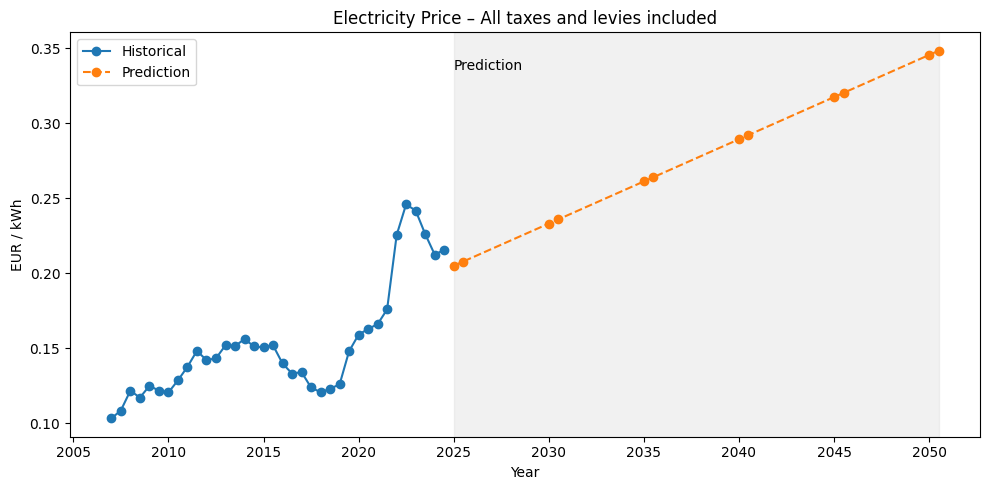

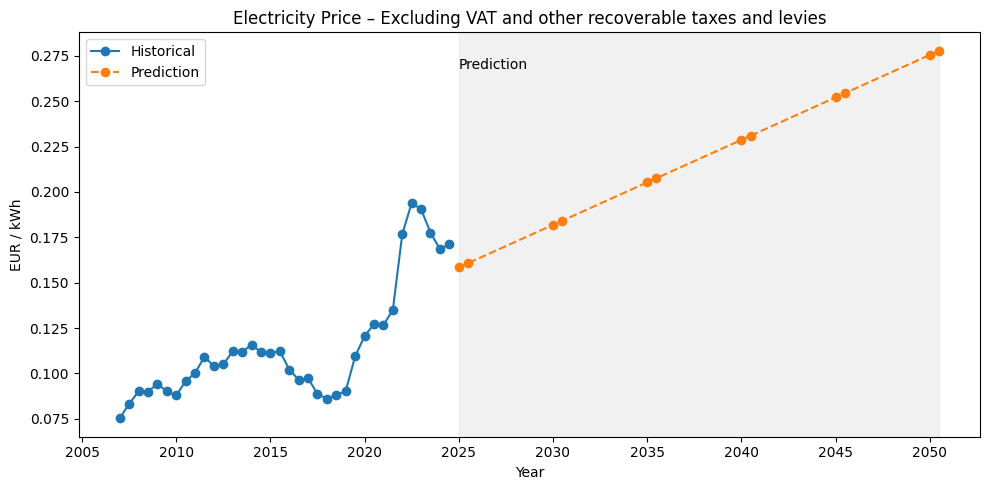

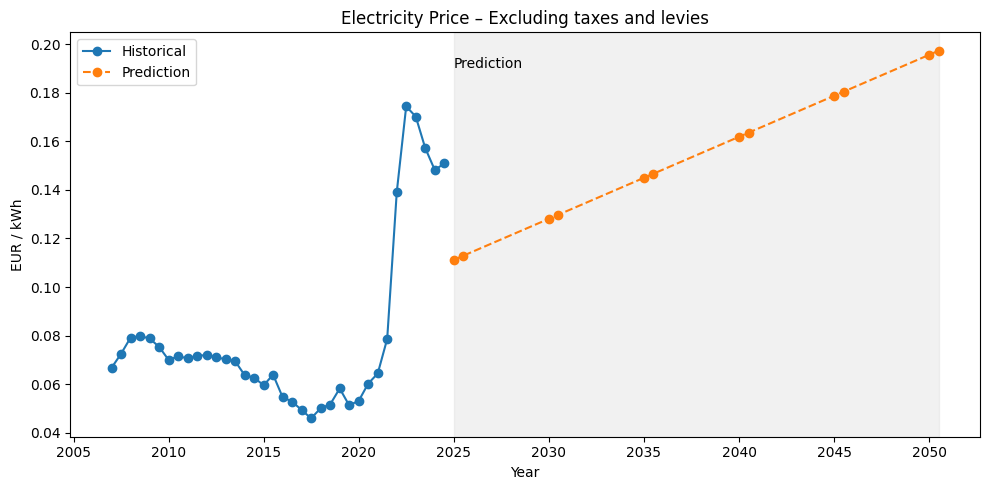

In [36]:

for preisart in df_prices_combined["Preisart"].unique():
    df_sub = df_prices_combined[df_prices_combined["Preisart"] == preisart]

    fig, ax = plt.subplots(figsize=(10, 5))

    # Historische Daten
    df_hist = df_sub[df_sub["Type"] == "Historical"]
    ax.plot(
        df_hist["ds"], df_hist["Preis_EUR_kWh"],
        label="Historical", marker="o", color="#1f77b4"
    )

    # Prognose-Daten
    df_prog = df_sub[df_sub["Type"] == "Predicted"]
    ax.plot(
        df_prog["ds"], df_prog["Preis_EUR_kWh"],
        label="Prediction", linestyle="--", marker="o", color="#ff7f0e"
    )

    # Schattierung ab 2025
    ax.axvspan(pd.to_datetime("2025-01-01"), df_sub["ds"].max(), color="lightgray", alpha=0.3)
    ax.text(pd.to_datetime("2025-01-01"), ax.get_ylim()[1]*0.95, "Prediction", verticalalignment="top")

    ax.set_title(f"Electricity Price – {preisart}")
    ax.set_ylabel("EUR / kWh")
    ax.set_xlabel("Year")
    ax.legend()
    plt.tight_layout()

    filename = f"{preisart.replace(' ', '_').replace('/', '_')}_halbjahr.png"
    fig.savefig(os.path.join(PLOT_OUT_DIR_BIANNUAL, filename), dpi=300)
    fig.show()
